In [4]:
import numpy as np
import pandas as pd
import glob
from pathlib import Path
import matplotlib.pyplot as plt
from scipy import stats
import os
from scipy.stats import sem
from matplotlib.lines import Line2D
import sys
import pickle
import spike.spike_analysis.firing_rate_calculations as fr
import spike.spike_analysis.spike_collection as collection
import spike.spike_analysis.spike_recording as recording
import spike.spike_analysis.single_cell as single_cell
import spike.spike_analysis.pca_trajectories as pca_trajectories

import pickle
import seaborn as sns
def hex_2_rgb(hex_color): # Orange color
    rgb_color = tuple(int(hex_color[i:i+2], 16) / 255.0 for i in (1, 3, 5))
    return rgb_color

def pickle_this(thing_to_pickle, file_name):
    """
    Pickles things
    Args (2):   
        thing_to_pickle: anything you want to pickle
        file_name: str, filename that ends with .pkl 
    Returns:
        none
    """
    with open(file_name,'wb') as file:
        pickle.dump(thing_to_pickle, file)

def unpickle_this(pickle_file):
    """
    Unpickles things
    Args (1):   
        file_name: str, pickle filename that already exists and ends with .pkl
    Returns:
        pickled item
    """
    with open(pickle_file, 'rb') as file:
        return(pickle.load(file))

c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [5]:
behavior_dicts = unpickle_this('pilot2/object_control/object_behavior_dicts.pkl')


In [6]:
print(behavior_dicts.keys())

new_behavior_dict = {}
subject_dict = {}
for rec, data in behavior_dicts.items():
    new_key = rec.split('_')[0] + '_' + rec.split('_')[1] + '_merged.rec'
    new_key = new_key.lower()
    new_behavior_dict[new_key] = data
    subject_dict[new_key] = str(int(rec.split('_')[0]) / 10)
print(subject_dict)


dict_keys(['22_object_CTBN.csv', '23_object_TBCN.csv', '31_object_BNTC.csv', '32_object_NBTC.csv', '41_object_BCNT.csv', '44_Object_TCNB.csv'])
{'22_object_merged.rec': '2.2', '23_object_merged.rec': '2.3', '31_object_merged.rec': '3.1', '32_object_merged.rec': '3.2', '41_object_merged.rec': '4.1', '44_object_merged.rec': '4.4'}


In [7]:
spike_path = r"C:\Users\megha\UFL Dropbox\Meghan Cum\Padilla-Coreano Lab\2024\Cum_SocialMemEphys_pilot2\Object_Control (phase 7)\sorted"
object_spikes = collection.SpikeCollection(spike_path, new_behavior_dict, subject_dict) 

loading  22_object_merged.rec
loading  31_object_merged.rec
loading  32_object_merged.rec
loading  41_object_merged.rec
loading  44_object_merged.rec


In [8]:
object_spikes.analyze(100, ignore_freq = 0.5)

All set to analyze


In [9]:
pickle_this(object_spikes, 'object_spikes.pkl')

Excluding 31_object_merged.rec with 1 neurons


c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


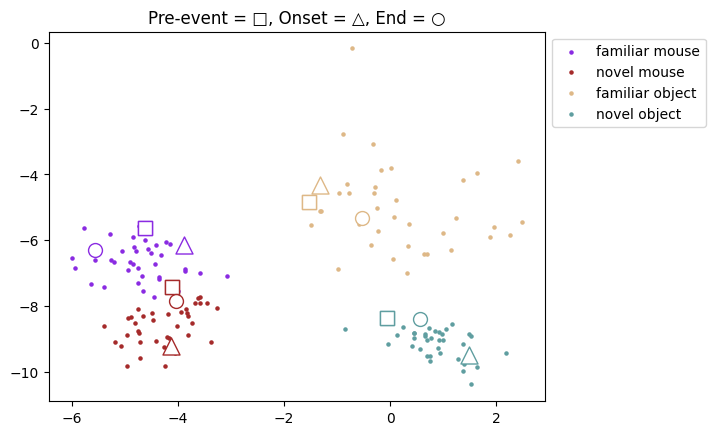

In [10]:
presults = pca_trajectories.avg_trajectories_pca(object_spikes, 3, pre_window = 1,
                                      events = ['familiar mouse', 'novel mouse', 'familiar object', 'novel object'],
                                      min_neurons = 4)


In [32]:
def plot_pca_results_3d(pca_result, title, colors, azim, elev, save = False):
    event_lengths = int(
            (pca_result.event_length + pca_result.pre_window + pca_result.post_window) * 1000 / pca_result.timebin
        )
    
    event_end = int((pca_result.event_length + pca_result.pre_window) * 1000 / pca_result.timebin)
    pre_window = pca_result.pre_window * 1000 / pca_result.timebin
    post_window = pca_result.post_window * 1000 / pca_result.timebin
    pc_var = pca_result.explained_variance
    PCA_key = pca_result.labels
    PCA_matrix = pca_result.transformed_data
    col_counter = 0
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(111, projection="3d")
    #plt.subplots_adjust(left=0.3, right=0.99, bottom=0.1, top=0.9)
    for i in range(0, len(PCA_key), event_lengths):
        event_label = PCA_key[i]
        onset = int(i + pre_window - 1)
        end = int(i + event_end - 1)
        post = int(i + event_lengths - 1)
        ax.plot3D(
            PCA_matrix[i : i + event_lengths, 0],
            PCA_matrix[i : i + event_lengths, 1],
            PCA_matrix[i : i + event_lengths, 2],
            label=event_label,
            color=colors[col_counter],
            linewidth = 5,
            alpha = 0.8
        )
        ax.scatter(
            PCA_matrix[i, 0],
            PCA_matrix[i, 1],
            PCA_matrix[i, 2],
            marker="s",
            s=100,
            c="w",
            edgecolors=colors[col_counter],
        )
        ax.scatter(
            PCA_matrix[onset, 0],
            PCA_matrix[onset, 1],
            PCA_matrix[onset, 2],
            marker="^",
            s=300,
            c="w",
            edgecolors=colors[col_counter],
        )
        ax.scatter(
            PCA_matrix[end, 0],
            PCA_matrix[end, 1],
            PCA_matrix[end, 2],
            marker="o",
            s=200,
            c="w",
            edgecolors=colors[col_counter],
        )
        if post_window != 0:
            ax.scatter(
                PCA_matrix[post, 0],
                PCA_matrix[post, 1],
                PCA_matrix[post, 2],
                marker="D",
                s=200,
                c="w",
                edgecolors=colors[col_counter],
            )
        col_counter += 1
    ax.legend(loc="upper left", bbox_to_anchor=(.9,1), frameon = False, fontsize = 14)
    # ax.set_xlim(-20, 45)
    # ax.set_ylim(-5, 25)
    # ax.set_zlim(-20, 30)
    ax.view_init(azim = azim, elev =elev)
    ax.set_title(f"{title}", fontsize = 24, y = 1)
    ax.set_xlabel(f"PC1 ({pc_var[0]*100:.1f}% variance)", fontsize = 16, labelpad = -10)
    ax.set_ylabel(f"PC2 ({pc_var[1]*100:.1f}% variance)", fontsize = 16, labelpad = -10)
    ax.set_zlabel(f"PC3 ({pc_var[2]*100:.1f}% variance)", fontsize = 16, labelpad = -10)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.yaxis.pane.set_alpha(0.9)
    ax.xaxis.pane.set_alpha(0.9)
    ax.zaxis.pane.set_alpha(0.9)
    plt.tight_layout()
    if save:
        plt.savefig(f'{title}.png', dpi = 600, transparent = True,bbox_inches='tight' )
    plt.show()


def plot_pca_results_2d(pca_result, title, colors, legend_spot, custom_legend_labels=None, save=False):
    event_lengths = int(
        (pca_result.event_length + pca_result.pre_window + pca_result.post_window) * 1000 / pca_result.timebin
    )
    
    event_end = int((pca_result.event_length + pca_result.pre_window) * 1000 / pca_result.timebin)
    pre_window = pca_result.pre_window * 1000 / pca_result.timebin
    post_window = pca_result.post_window * 1000 / pca_result.timebin
    pc_var = pca_result.explained_variance
    PCA_key = pca_result.labels
    PCA_matrix = pca_result.transformed_data
    col_counter = 0
    
    # Create figure with updated size
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)
    
    # Store generated handles
    legend_handles = []
    
    # Determine which labels to use
    if custom_legend_labels is None:
        # Use original labels from PCA_key
        unique_labels = []
        for i in range(0, len(PCA_key), event_lengths):
            if PCA_key[i] not in unique_labels:
                unique_labels.append(PCA_key[i])
        legend_labels = unique_labels
    else:
        # Use the custom labels
        legend_labels = custom_legend_labels
    
    for i in range(0, len(PCA_key), event_lengths):
        event_label = PCA_key[i]
        onset = int(i + pre_window - 1)
        end = int(i + event_end - 1)
        post = int(i + event_lengths - 1)
        
        # Plot the continuous line with updated styling (no labels here)
        line = ax.plot(
            PCA_matrix[i:i + event_lengths, 0],
            PCA_matrix[i:i + event_lengths, 1],
            color=colors[col_counter],
            linewidth=5,
            alpha=0.8,
            zorder=1
        )[0]
        
        # Only add unique handles to the legend
        if col_counter < len(legend_labels) and line not in legend_handles:
            legend_handles.append(line)
        
        # Add markers with updated sizes
        ax.scatter(
            PCA_matrix[i, 0],
            PCA_matrix[i, 1],
            marker="s",
            s=200,
            c="w",
            edgecolors=colors[col_counter],
            zorder=2
        )
        ax.scatter(
            PCA_matrix[onset, 0],
            PCA_matrix[onset, 1],
            marker="^",
            s=300,
            c="w",
            edgecolors=colors[col_counter],
            zorder=3
        )
        ax.scatter(
            PCA_matrix[end, 0],
            PCA_matrix[end, 1],
            marker="o",
            s=200,
            c="w",
            edgecolors=colors[col_counter],
            zorder=4
        )
        if post_window != 0:
            ax.scatter(
                PCA_matrix[post, 0],
                PCA_matrix[post, 1],
                marker="D",
                s=200,
                c="w",
                edgecolors=colors[col_counter],
                zorder=5
            )
        col_counter += 1
    
    # Create legend with the collected handles and the appropriate labels
    ax.legend(
        handles=legend_handles[:len(legend_labels)],  # Ensure we don't have more handles than labels
        labels=legend_labels,
        loc="upper left", 
        bbox_to_anchor=legend_spot, 
        frameon=False, 
        fontsize=14
    )
    
    # Updated title and label formatting
    ax.set_title(f"{title}", fontsize=24, y=1.01)
    ax.set_xlabel(f"PC1 ({pc_var[0]*100:.1f}% variance)", fontsize=16)
    ax.set_ylabel(f"PC2 ({pc_var[1]*100:.1f}% variance)", fontsize=16)
    
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.set_xticks([])
    
    # Add tight layout
    plt.tight_layout()
    
    if save:
        plt.savefig(f'{title}.png', dpi=600, transparent=True, bbox_inches='tight')
    plt.show()
    


In [25]:
object_spikes.analyze(timebin=100, ignore_freq = 0.5, smoothing_window=500)
results = pca_trajectories.avg_trajectories_pca(object_spikes, 3, pre_window = 1,
                                      events = ['familiar mouse', 'novel mouse', 'familiar object', 'novel object'],
                                      min_neurons = 4,
                                      plot = False)


All set to analyze
Excluding 31_object_merged.rec with 1 neurons


c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


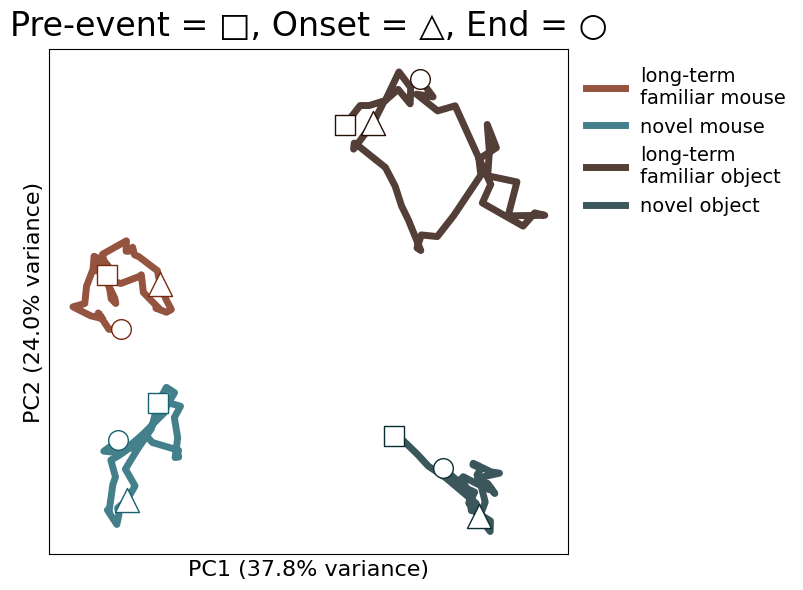

PCA Result with:
Events: familiar mouse, novel mouse, familiar object, novel object
Timebins per event: 40.0
Total neurons: 37
Number of recordings: 4
Number of Pcs needed to explain 90% of variance 7


In [37]:
plot_pca_results_2d(results, title = "Pre-event = □, Onset = △, End = ○", colors =['#792910','#15616F','#290e06','#0a2d33'], legend_spot = (1,1), custom_legend_labels = ['long-term\nfamiliar mouse',
'novel mouse', 'long-term\nfamiliar object', 'novel object']  )
print(results)

C:\Users\megha\AppData\Local\Temp\ipykernel_12448\671182016.py:83: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


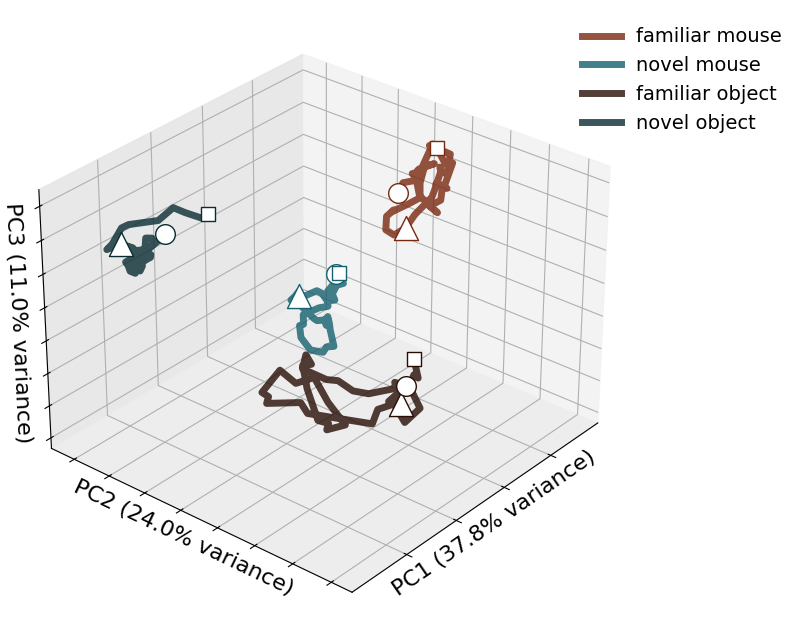

In [28]:
plot_pca_results_3d(results, title = '', colors =['#792910','#15616F','#290e06','#0a2d33'], azim = 40, elev = 30)

Excluding 31_object_merged.rec with 1 neurons


c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


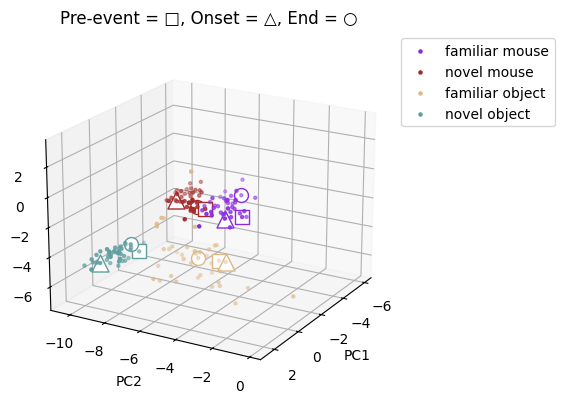

              Recording  Number of Neurons  Number of familiar mouse events  \
0  41_object_merged.rec                 16                               21   
1  22_object_merged.rec                  9                               11   
2  32_object_merged.rec                  8                               12   
3  44_object_merged.rec                  4                               14   

   Number of novel mouse events  Number of familiar object events  \
0                            11                                 5   
1                            26                                10   
2                            25                                 8   
3                            13                                 1   

   Number of novel object events  
0                             18  
1                             24  
2                             16  
3                             14  

In [14]:
pca_trajectories.avg_trajectories_pca(object_spikes, 3, pre_window = 1,
                                      events = ['familiar mouse', 'novel mouse', 'familiar object', 'novel object'],
                                      min_neurons = 4, d = 3)

c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
C:\Users\megha\AppData\Local\Temp\ipykernel_23420\2465639922.py:68: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "//". Passing invalid values is deprecated since 3.4 and will become an error in 3.9.
  legend_handles = [Patch(facecolor=color, label=label, hatch = hatches) for label, color in color_id_dict.items()]


Excluding 31_object_merged.rec with 1 neurons
Excluding 44_object_merged.rec with 4 neurons


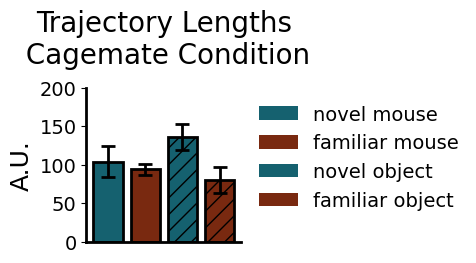

,Comparison,t_statistic,p_value,p_adjusted,significant
0,nov_fam,0.424281,0.712641,0.856857,False
1,nov_cage,-0.985097,0.428429,0.856857,False
2,fam_cage,-4.105450,0.054524,0.163571,False


In [26]:
from scipy.spatial.distance import euclidean
from matplotlib.patches import Patch
from statsmodels.stats.multitest import multipletests
import matplotlib.ticker as ticker
events = ['familiar mouse', 'novel mouse', 'familiar object', 'novel object']
def trajectory_length(pca_matrix, key):
    trajectory_lengths = []
    event_order = []
    unique_values, counts = np.unique(key, return_counts=True)
    event_len = counts[0]
    for j in range(0, len(key), event_len):
        trajectory_length = 0
        for i in range(event_len-1):
            trajectory_length = trajectory_length + euclidean(
                pca_matrix[j+i, :3],
                pca_matrix[j+i+1, :3])
        trajectory_lengths.append(trajectory_length)
        event_order.append(key[j])
    return [trajectory_lengths, event_order]

trajectory_lengths = []
orders= []
for recording in object_spikes.recordings:
    pc_dict = pca_trajectories.avg_trajectories_pca(recording, event_length = 5, pre_window = 3,
                                                 events = events, min_neurons=5, plot = False)
    if pc_dict:
        [traj_len, event_order] = trajectory_length(pc_dict.transformed_data,
                                                pc_dict.labels)
        trajectory_lengths.append(traj_len)
        orders.append(event_order)
trajectory_lengths = np.array(trajectory_lengths)



# means = np.mean(trajectory_lengths, axis = 0)
# sems = sem(trajectory_lengths, axis = 0)

# t_nov_fam, p_nov_fam = stats.ttest_rel(trajectory_lengths[:,0], trajectory_lengths[:,1])
# t_nov_cage, p_nov_cage = stats.ttest_rel(trajectory_lengths[:,0], trajectory_lengths[:,2])
# t_fam_cage, p_fam_cage = stats.ttest_rel(trajectory_lengths[:,1], trajectory_lengths[:,2])
# p_values = [p_nov_fam, p_nov_cage, p_fam_cage]
# reject, p_adjusted, _, _ = multipletests(p_values, method='holm')
# stats_df = pd.DataFrame({
#    'Comparison': ['nov_fam', 'nov_cage', 'fam_cage'],
#    't_statistic': [t_nov_fam, t_nov_cage, t_fam_cage],
#    'p_value': p_values,
#    'p_adjusted': p_adjusted,
#    'significant': reject
# })

# Adjust p-values using Holm-Bonferroni
p_values = [p_nov_fam, p_nov_cage, p_fam_cage]
reject, p_adjusted, _, _ = multipletests(p_values, method='holm')
color_id_dict = {'novel mouse': hex_2_rgb('#15616F'), 
                'familiar mouse': hex_2_rgb('#792910'),
                  'novel object': hex_2_rgb('#15616F'),
                  'familiar object': hex_2_rgb('#792910')}
hatches = ['','','//','//']
x = [0.5,1,1.5,2]
plt.figure(figsize= (2,2))           
plt.bar(x, means, yerr = sems,
            color = color_id_dict.values(), hatch = hatches,
            edgecolor = ['black', 'black', 'black', 'black'],
            capsize = 5, linewidth = 2,
            error_kw={'elinewidth': 2, 'capthick': 2}, 
            width = .4)
plt.xticks([],rotation=45)
legend_handles = [Patch(facecolor=color, label=label, hatch = hatches) for label, color in color_id_dict.items()]
plt.legend(handles=legend_handles,
           bbox_to_anchor=(1,1),
           frameon= False, fontsize = 14)
plt.ylabel('A.U.', fontsize = 18)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(50))
plt.ylim(0,200)

plt.gca().spines['bottom'].set_linewidth(2)  # X-axis
plt.gca().spines['left'].set_linewidth(2) 
plt.title('Trajectory Lengths\n Cagemate Condition', fontsize = 20, y = 1.1)
plt.show()

stats_df

In [ ]:
import numpy as np
import scipy.stats as stats

def circular_distance(alpha, beta):
    """Calculate the circular distance between two sets of angles in radians"""
    return np.angle(np.exp(1j * alpha) / np.exp(1j * beta))

# Assuming we have these variables defined:
# cell_ts_off - spike timestamps
# Ph_OFF - a function that returns phases at given timestamps
# LFPinsoff - indices of LFP at spike times
# unit - current unit being analyzed
# PPCthetabla - array to store results

if len(cell_ts_off) > 100:
    # Extract spike phases
    spikes_phases_off = Ph_OFF(LFPinsoff).T
    
    # Create matrices for all pairwise comparisons
    temp1 = np.tile(spikes_phases_off, (len(spikes_phases_off), 1))
    temp2 = temp1.T
    
    # Calculate absolute circular distance between all pairs
    temp3 = np.abs(circular_distance(temp1, temp2))
    
    # Create identity matrix with same dimensions
    add_nans = np.eye(temp1.shape[0])
    
    # Replace ones with NaN
    add_nans[add_nans == 1] = np.nan
    
    # Add NaNs to diagonal
    temp3 = temp3 + add_nans
    
    # Calculate PPC
    PPCthetabla[unit, 0] = (np.pi - 2 * np.nanmean(np.nanmean(temp3))) / np.pi
else:
    # Not enough spikes
    PPCthetabla[unit, 0] = np.nan